# CoCoScore Implementation

This notebook consists of implementing the [CoCoScore](https://www.biorxiv.org/content/10.1101/444398v1) literature model for comparison. We report performance as area under the precision recall curve (AUPR) and area under the receiver operating curve (AUROC). In both cases the greater the area the better the model is.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import os
import pickle
import re
import sys

sys.path.append(os.path.abspath('../../../../modules'))

import operator
from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, accuracy_score, confusion_matrix
from tqdm import tqdm_notebook

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.learning.pytorch.rnn.rnn_base import mark_sentence
from snorkel.learning.pytorch.rnn.utils import candidate_to_tokens
from snorkel.models import Candidate, candidate_subclass

from metal.analysis import lf_summary
from metal.label_model import LabelModel
from metal.utils import plusminus_to_categorical

from gensim.models import FastText
from gensim.models import KeyedVectors

from utils.notebook_utils.label_matrix_helper import label_candidates, get_auc_significant_stats
from utils.notebook_utils.dataframe_helper import load_candidate_dataframes, generate_results_df
from utils.notebook_utils.plot_helper import plot_curve, plot_label_matrix_heatmap

In [4]:
GeneGene = candidate_subclass('GeneGene', ['Gene1', 'Gene2'])

In [5]:
quick_load = True

In [6]:
total_candidates_df = pd.read_table("../../dataset_statistics/results/all_gig_candidates.tsv.xz")
total_candidates_df.head(2)

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,gene1_id,gene1_name,gene2_id,gene2_name,sources,n_sentences,hetionet,has_sentence,split,partition_rank,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
0,1,A1BG,10321,CRISP3,II_literature|hetio-dag,5,1,1,3,0.436432,0.0,0.0,2,65570963,Human CRISP-3 binds serum alpha(1)B-glycoprote...,11,20992573
1,1,A1BG,10321,CRISP3,II_literature|hetio-dag,5,1,1,3,0.436432,0.0,0.0,3,65570968,BACKGROUND: CRISP-3 was previously shown to be...,21,20930188


In [7]:
spreadsheet_names = {
    'dev': '../../data/sentences/sentence_labels_dev.xlsx',
    'test': '../../data/sentences/sentence_labels_test.xlsx'
}

In [8]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key], "curated_gig")
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of dev set: 500
Size of test set: 500


In [10]:
distant_supervision_marginals = (
    pd.read_table("../../label_sampling_experiment/results/GiG/marginals/baseline_marginals.tsv.xz")
    .assign(labels=lambda x: x.pos_class_marginals.apply(lambda y: 1 if y > 0.5 else 0))
)
distant_supervision_marginals.head(2)

,pos_class_marginals,neg_class_marginals,candidate_id,labels
0,0.01,0.99,25627,0
1,0.01,0.99,25628,0


In [11]:
word_dict = pd.read_table("../../word_vector_experiment/results/gene_interacts_gene_word_dict.tsv", keep_default_na=False)
reverse_word_dict = dict(zip(word_dict.index, word_dict.word))
word_dict = dict(zip(word_dict.word, word_dict.index))

In [12]:
curated_ids = {}
curated_ids['train'] = dict(zip(distant_supervision_marginals.candidate_id, distant_supervision_marginals.labels))
curated_ids['dev'] = dict(zip(candidate_dfs['dev'].candidate_id, candidate_dfs['dev'].curated_gig))
curated_ids['test'] = dict(zip(candidate_dfs['test'].candidate_id, candidate_dfs['test'].curated_gig))

In [ ]:
search_regex = rf'(\b{word_dict["~~[[2"]}\b.+\b{word_dict["2]]~~"]}\b,)'
search_regex += rf'|(\b{word_dict["~~[[1"]}\b.+\b{word_dict["1]]~~"]}\b,)'

all_sentences = pd.read_table("../../word_vector_experiment/results/all_embedded_gg_sentences.tsv.xz", chunksize=1e6)
with open("training.txt", "w") as train, open("dev.txt", "w") as dev:
    with open("test.txt", "w") as test, open("all_gg_sentences.txt", "w") as all_sen:
        for chunk in all_sentences:
            for index, row in tqdm_notebook(chunk.iterrows()):
                cand_str = ",".join(map(str, row.dropna().astype(int).values))
                pruned_str = re.sub(search_regex, "", cand_str)
                values = list(map(int, pruned_str.split(",")))
                
                if row['candidate_id'] in curated_ids['train']:
                    train.write(f"__label__{curated_ids['train'][row['candidate_id']]}\t")
                    train.write("\t".join([reverse_word_dict[val] for val in values[:-2]]))
                    train.write("\n")
                    
                elif row['candidate_id'] in curated_ids['dev']:
                    dev.write(f"__label__{curated_ids['dev'][row['candidate_id']]}\t")
                    dev.write("\t".join([reverse_word_dict[val] for val in values[:-2]]))
                    dev.write("\n")
                    
                elif row['candidate_id'] in curated_ids['test']:
                    test.write(f"__label__{curated_ids['test'][row['candidate_id']]}\t")
                    test.write("\t".join([reverse_word_dict[val] for val in values[:-2]]))
                    test.write("\n")

                all_sen.write(f"__label__{0}\t")
                all_sen.write("\t".join([reverse_word_dict[val] for val in values[:-2]]))
                all_sen.write("\n")

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [16]:
os.system("../../../../../fastText/fasttext supervised -input training.txt -output gig_model -lr 0.005 -epoch 50 -dim 300 -wordNgrams 2")
os.system("../../../../../fastText/fasttext predict-prob gig_model.bin dev.txt > dev_predictions.tsv")
os.system("../../../../../fastText/fasttext predict-prob gig_model.bin test.txt > test_predictions.tsv")

0

In [19]:
precision, recall, _ = precision_recall_curve(
    candidate_dfs['dev'].curated_gig,
    pd.read_table('dev_predictions.tsv', header=None, sep=" ")[1]
)
auc(recall, precision)

0.09069850973015092

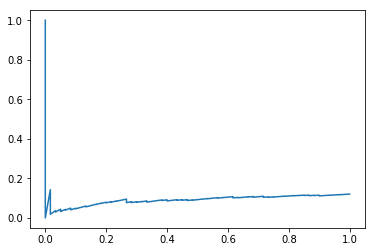

In [20]:
plt.plot(recall, precision)

In [22]:
fpr, tpr, _ = roc_curve(
    candidate_dfs['dev'].curated_gig,
    pd.read_table('dev_predictions.tsv', header=None, sep=" ")[1]
)
auc(fpr, tpr)

0.3853598484848485

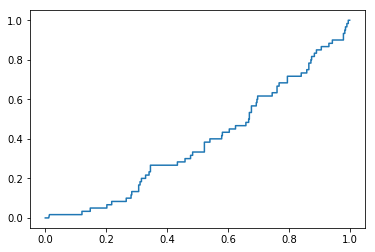

In [23]:
plt.plot(fpr, tpr)

In [27]:
os.system("../../../../../fastText/fasttext predict-prob gig_model.bin all_gg_sentences.txt > all_gg_sentences_predictions.tsv")

0

In [28]:
predictions_df = pd.read_table("all_gg_sentences_predictions.tsv", header=None, names=["label", "predictions"], sep=" ")
predictions_df['candidate_id'] = pd.read_table("../../word_vector_experiment/results/all_embedded_gg_sentences.tsv.xz", usecols=["candidate_id"]).candidate_id.values
predictions_df.head(2)

,label,predictions,candidate_id
0,__label__0,0.954450,25627
1,__label__0,0.971491,25628


In [29]:
final_pred_df = (
    total_candidates_df
    [["gene1_id", "gene2_id", "candidate_id"]]
    .merge(predictions_df[["predictions", "candidate_id"]])
)
final_pred_df.head(2)

,gene1_id,gene2_id,candidate_id,predictions
0,1,10321,20930188,0.976340
1,1,10321,20930177,0.989237


In [30]:
added_scores_df = (
    final_pred_df
    .groupby(["gene1_id", "gene2_id"])
    .aggregate({"predictions": 'sum'})
    .reset_index()
)
added_scores_df.head(2)

,gene1_id,gene2_id,predictions
0,1,1,22.815910
1,1,2,0.844404


In [33]:
total_score = added_scores_df.predictions.sum()
gene_scores = added_scores_df.groupby("gene1_id").agg({"predictions":"sum"}).reset_index()
gene_scores = dict(zip(gene_scores.gene1_id, gene_scores.predictions))
drug_scores = added_scores_df.groupby("gene2_id").agg({"predictions":"sum"}).reset_index()
drug_scores = dict(zip(drug_scores.gene2_id, drug_scores.predictions))

alpha=0.65

final_scores_df = added_scores_df.assign(
    final_score=(
        added_scores_df.apply(
            lambda x: pd.np.exp(
                    alpha*pd.np.log(x['predictions']) + (1-alpha)*(
                    pd.np.log(x['predictions']) + pd.np.log(total_score) - 
                    pd.np.log(gene_scores[x['gene1_id']]) - pd.np.log(drug_scores[x['gene2_id']])
                )
            ), 
            axis=1
        )
    )
)
final_scores_df.head(2)

,gene1_id,gene2_id,predictions,final_score
0,1,1,22.815910,179.644016
1,1,2,0.844404,2.177841


In [35]:
score_with_labels_df = (
    final_scores_df
    .merge(
        total_candidates_df[["gene1_id", "gene2_id", "hetionet"]],
        on=["gene1_id", "gene2_id"]
    )
    .drop_duplicates()
)
score_with_labels_df.head(2)

,gene1_id,gene2_id,predictions,final_score,hetionet
0,1,1,22.815910,179.644016,0
34,1,2,0.844404,2.177841,0


In [37]:
score_with_labels_df.drop("predictions", axis=1).to_csv("gg_edge_prediction_cocoscore.tsv", sep="\t", index=False)

In [36]:
fpr, tpr, _ = roc_curve(score_with_labels_df.hetionet, score_with_labels_df.final_score)
print(auc(fpr, tpr))

precision, recall, _ = precision_recall_curve(score_with_labels_df.hetionet, score_with_labels_df.final_score)
print(auc(recall, precision))

0.7209766140840459
0.09901961330531939
